In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from tensorflow.keras import backend as K

import logging
tf.get_logger().setLevel(logging.ERROR)

2021-08-01 03:54:49.214753: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Check GPU
tf.config.list_physical_devices('GPU')

2021-08-01 03:54:53.566679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-01 03:54:54.190644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-01 03:54:54.191909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-01 03:54:54.191988: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-01 03:54:54.219250: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-08-01 03:54:54.235720: I tensorflow/stream_executor/platform/default/d

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Use Twitter and Reddit data to train a Bert Model

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

2021-08-01 03:54:57.769907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2021-08-01 03:54:57.770054: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ed04b5d90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-01 03:54:57.770068: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-01 03:54:57.880869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-01 03:54:57.881515: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ed27ff600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-08-01 03:54:57.881530: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2021-08-0

In [4]:
def create_classification_model(max_length,
                                hidden_size = 256, 
                                train_layers = -1,
                                classes = 1,
                                sequence = True,
                                optimizer=tf.keras.optimizers.Adam()):
    """
    We will use this first to classify Misogynous/not, and then create a separate model to classify they type
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)[0]

    dense_inputs = tf.keras.layers.Reshape((768*max_length, ))(bert_out)
    dense_inputs = tf.keras.layers.LayerNormalization()(dense_inputs)

    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(dense_inputs)    
    hidden = tf.keras.layers.Dropout(rate=0.1)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [5]:
reddit_data = pd.read_pickle("reddit_labels.pkl")
twitter_data = pd.read_pickle("twitter_labels.pkl")

In [6]:
model_training = reddit_data.append(twitter_data).sample(frac=1).reset_index(drop=True)
model_training['Misogyny'] = [0 if i == 'Non' else 1 for i in model_training.new_class]
#model_training['Misogyny_class'] = [1 if i == 'Derogation-Discredit' else
#                                    2 if i == 'Derailing-Attacks' else 
#                                    3 if i == 'Dominance' else
#                                    4 if i == 'Threatening-Harassment' else 
#                                    5 if i == 'Objectification-Stereotyping' 
#                                    else 0 for i in model_training.new_class] 
model_training['Misogyny_class'] = [1 if i == 'Derogation' else
                                    2 if i == 'Treatment' else 
                                    0 for i in model_training.new_class] 

In [7]:
training_data = model_training[model_training.split == 'train'].drop(columns='split').reset_index(drop=True)
testing_data = model_training[model_training.split == 'test'].drop(columns='split').reset_index(drop=True)

In [8]:
training_data.Misogyny.value_counts()

0    6839
1    2095
Name: Misogyny, dtype: int64

In [37]:
# Experimentation with dropping data to have even class representation:
#non_misgyny = training_data[training_data.Misogyny == 0].reset_index(drop=True)[0:2095]
#training_data = training_data[training_data.Misogyny == 1].append(non_misgyny).sample(frac=1).reset_index(drop=True)

# First model, for misogyny or not:

In [8]:
max_length = 75

train_data = np.array(training_data.body)
test_data = np.array(testing_data.body)

x_train = tokenizer([x for x in train_data], 
                    max_length=max_length,
                    truncation=True,
                    padding='max_length', 
                    return_tensors='tf')

x_test = tokenizer([x for x in test_data],
                   max_length=max_length,
                   truncation=True,
                   padding='max_length', 
                   return_tensors='tf')

In [9]:
y_train = np.array(training_data.Misogyny)
y_test = np.array(testing_data.Misogyny)

In [11]:
epochs = 3

misogyny_model_2 = create_classification_model(max_length, train_layers = 2,
                                             optimizer=tf.keras.optimizers.Adam(0.00001))     
misogyny_model_2.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                    y_train,
                    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                    y_test),
                    epochs=epochs,
                    batch_size=8)

Epoch 1/3
1117/1117 [==============================] - 89s 80ms/step - loss: 0.3211 - accuracy: 0.8704 - val_loss: 0.6371 - val_accuracy: 0.8023
Epoch 2/3
1117/1117 [==============================] - 86s 77ms/step - loss: 0.1525 - accuracy: 0.9407 - val_loss: 0.6419 - val_accuracy: 0.7777
Epoch 3/3
1117/1117 [==============================] - 86s 77ms/step - loss: 0.0898 - accuracy: 0.9655 - val_loss: 0.6922 - val_accuracy: 0.7996


In [52]:
test_pred = misogyny_model_2.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=8)
pred_0or1 = np.array([1 if i > 0.5 else 0 for i in test_pred])

In [17]:
print('predict on top: 0, 1:')
tf.math.confusion_matrix(
    y_test,
    pred_0or1,
    num_classes=2)

predict on top: 0, 1:


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1466,  236],
       [ 211,  318]], dtype=int32)>

# Now we need another model to determine the class of misogyny:

In [9]:
max_length = 75

train_data = np.array(training_data[training_data.Misogyny == 1].body)
test_data = np.array(testing_data[testing_data.Misogyny == 1].body)

x_train = tokenizer([x for x in train_data], 
                    max_length=max_length,
                    truncation=True,
                    padding='max_length', 
                    return_tensors='tf')

x_test = tokenizer([x for x in test_data],
                   max_length=max_length,
                   truncation=True,
                   padding='max_length', 
                   return_tensors='tf')

In [10]:
y_train = np.array(training_data[training_data.Misogyny == 1].Misogyny_class) - 1
y_test = np.array(testing_data[testing_data.Misogyny == 1].Misogyny_class) - 1

In [14]:
epochs = 3

misogyny_class_model = create_classification_model(max_length, train_layers = 1,
                                             optimizer=tf.keras.optimizers.Adam(0.00001))    
misogyny_class_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                          y_train,
                          validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                          y_test),
                          epochs=epochs,
                          batch_size=8)

Epoch 1/3
262/262 [==============================] - 23s 89ms/step - loss: 0.5064 - accuracy: 0.7819 - val_loss: 1.0078 - val_accuracy: 0.6805
Epoch 2/3
262/262 [==============================] - 21s 79ms/step - loss: 0.2485 - accuracy: 0.9084 - val_loss: 1.0508 - val_accuracy: 0.6711
Epoch 3/3
262/262 [==============================] - 20s 78ms/step - loss: 0.1232 - accuracy: 0.9589 - val_loss: 1.0270 - val_accuracy: 0.7013


In [17]:
test_pred = misogyny_class_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=8)
pred_class = np.array([1 if i > 0.5 else 0 for i in test_pred])

In [18]:
conf_mat = tf.math.confusion_matrix(
    y_test,
    pred_class,
    num_classes=2)
conf_mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[298,  49],
       [109,  73]], dtype=int32)>

# Now apply models to song data:

In [32]:
#song_data_all = pd.read_pickle("song_data_all.pkl")
song_data_2000s = pd.read_pickle("song_data_2000s.pkl")

In [33]:
broken_up_lyrics = song_data_2000s[song_data_2000s.Artist == 'clear df']
for i in range(len(song_data_2000s)):
    lyrics = song_data_2000s.Lyrics[i].split()
    row = song_data_2000s.loc[i].copy()
    start_point = 0
    while start_point < len(lyrics):
        row['Lyrics'] =  " ".join(lyrics[start_point:start_point+50])
        broken_up_lyrics = broken_up_lyrics.append(row)
        start_point += 40

In [34]:
max_length = 75

song_lyrics = np.array(broken_up_lyrics.Lyrics)

tokenize_lyrics = tokenizer([x for x in song_lyrics], 
                            max_length=max_length,
                            truncation=True,
                            padding='max_length', 
                            return_tensors='tf')

In [35]:
song_lyric_pred = misogyny_model_2.predict([tokenize_lyrics.input_ids, tokenize_lyrics.token_type_ids, tokenize_lyrics.attention_mask], batch_size=8)
misogyny_0or1 = np.array([1 if i > 0.5 else 0 for i in song_lyric_pred])

In [180]:
broken_up_lyrics['Misogynistic_Subsets'] = misogyny_0or1
misogyny_results = broken_up_lyrics.groupby(['Artist', 'Song Name', 'Year']).sum().reset_index()
misogyny_results['Misogyny'] = [1 if i > 2 else 0 for i in misogyny_results['Misogynistic_Subsets']]
misogyny_results[misogyny_results.Misogyny == 1].sort_values('Year')

,Artist,Song Name,Year,Misogynistic_Subsets,Misogyny
449,Da Brat,What'Chu Like,2000,5,1
1585,Ricky Martin,She Bangs,2000,8,1
813,JAY,Anything,2000,4,1
629,Evan And Jaron,Crazy For This Girl,2000,3,1
817,JAY,I Just Wanna Love U,2000,5,1
...,...,...,...,...,...
437,DJ Khaled,Jealous,2019,5,1
1383,"Mustard, Migos",Pure Water,2019,10,1
1162,"Lil Nas X, Cardi B",Rodeo,2019,3,1
1169,Lil Uzi Vert,Sanguine Paradise,2019,7,1


Text(0.5, 1.0, "Percent of Year's Top 100 Songs Deemed to Contain Misogyny from 2000-2019")

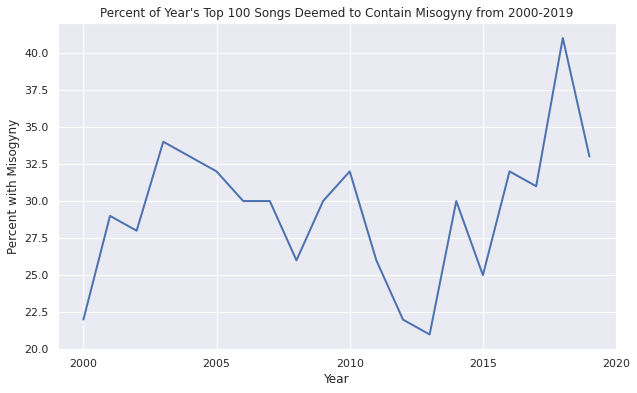

In [195]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
graph_data = misogyny_results[['Year', 'Misogyny']].groupby(['Year']).sum()
g = sns.lineplot(data=graph_data, x="Year", y="Misogyny", linewidth = 2)
g.set_xticks(list(range(2000,2021, 5))) 
g.set_xticklabels(list(range(2000,2021, 5)))
plt.ylabel("Percent with Misogyny")
plt.title("Percent of Year's Top 100 Songs Deemed to Contain Misogyny from 2000-2019")

In [62]:
max_length = 75

misogynous_lyrics = np.array(broken_up_lyrics[broken_up_lyrics.Misogynistic_Subsets == 1].Lyrics)

tokenize_lyrics = tokenizer([x for x in misogynous_lyrics], 
                            max_length=max_length,
                            truncation=True,
                            padding='max_length', 
                            return_tensors='tf')

In [63]:
misogyny_class_pred = misogyny_class_model.predict([tokenize_lyrics.input_ids, tokenize_lyrics.token_type_ids, tokenize_lyrics.attention_mask], batch_size=8)
misogyny_pred_class = np.array([1 if i > 0.5 else 0 for i in misogyny_class_pred])

In [65]:
misogyny_pred_class.mean()

0.8251677170156536